# 0. Install and Import Dependencies

To check Python packages and their versions in the current environment we used below command.

In [1]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.6
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.1.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.13.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bidict                           0.22.1
b

- Computer vision tasks - opencv
- Data visualization - Matplotlib
- Image input/output - imageio
- Downloading files from Google drive - gdown
- Deep Learning - Tensorflow.

In [2]:
!pip install opencv-python matplotlib imageio gdown tensorflow

1. Opencv
- Open Source Computer Vision(opencv) is a library which provides tools for computer vision and image processing tasks.
- It includes a variety of functions for tasks like image and video manipulation, object detection, and feature extraction.
2. matplotlib: Matplotlib is used for visualization

3. imageio: used to interface to read & write images in various formats & used for handling image input and output operations.

4. gdown: Used to download files from google drive.

5. tensorflow: It is open-source machine learning framework used for building and training machine learning models like deep neural networks.

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

Before starting to load data, lets check the GPU devices availability within the TensorFlow configuration system, which is crucial for optimizing deep learning tasks that can benefit from GPU Acceleration

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [6]:
import gdown

In [8]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: /content/data.zip
100%|██████████| 423M/423M [00:06<00:00, 64.6MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

Here, we loaded a video and the it is processes each frame, converts each frame into grayscale and extracting a region of interest.

The frames are normalized by substracting the mean and dividing by the standard deviation before being returned as a TensorFlow.

In [7]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

A list is created to represent vocabulary for future text in the extracted data from the videos.

In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

Here we defined two Tensorflow StringLookup layers, 'char_to_num' & 'num_to_char', for mapping characters to numerical indices and vice versa.

This vocabulary is based on the 'vocab' list in the above.

In [9]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


Here, this returns a list of unique characters that the layer has been configured to map to numerical indices.

In [10]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [11]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [12]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

Here, 'load_alignments', used to read lines from file then extract the tokens, converts them to their corresponding numerical index using char_to_num StringLookuo layer.

The resulting list of numerical index is returned excluding the first element in the list.

Overall, the function is designed to process alignments data and converts it into a format suitable for further analysis in comming steps.

In [13]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

load_data function, takes the file path as input and then it decodes it, extracts the file name, and constructs paths for corresponding video and alignment files.

It then processes the video frames and alignments. Finally, it returns a tuple for further data analysis.

In [24]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    #file_name = path.split('\\')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

Taking a video file for testing

In [16]:
test_path = '.\\data\\s1\\bbal6n.mpg'

It gives base filename(without extension) from given video file path.

In [17]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

Here load_data function is called to process video frames and alignments for the given test_path.

In [18]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

40th frame of the video is displayed below. Here, the frames is a list of array from above line and the frames of video is strored in it, with index to each frame converted to a image from video.

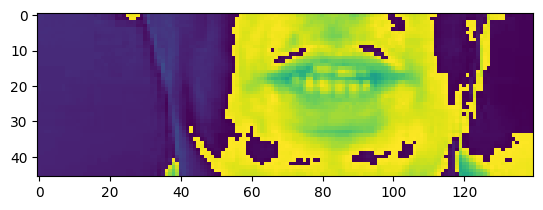

In [19]:
plt.imshow(frames[40])

In [20]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

Here num_char converted numerical indices to characters and then joined them into a single string using TensorFlow 'reduce_join' function to a sentence level output.

In [21]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

The 'mappable_function' is a TensorFlow-compatible mapping function. It is used to dataset API for efficient data loading and preprocessing.

In [22]:
from typing import Tuple
def mappable_function(path:str) ->Tuple[tf.Tensor, tf.Tensor]:
  result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
  return result

# 2. Create Data Pipeline

In [25]:
from matplotlib import pyplot as plt

We are creating a TensorFlow dataset pipeline for the video data:

Loaded file paths, shuffled them, applied a mapping function to load and preprocess data, created batches with padding, and splitted the dataset into training and testing subsets.
The dataset is splitted into training subset of 450 and remaining is testing subset.

In [26]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

The lenght of train is 450 & the length of test is 50

In [27]:
len(test)

50

Here, we created an iterator for the training dataset, converted it to a NumPy iterator, and extracted the next batch of frames and alignments(frames, alignments) for training a model.

In [28]:
train_iterator = train.as_numpy_iterator()
frames, alignments = train_iterator.next()


In [29]:
len(frames)

2

In [30]:
sample = data.as_numpy_iterator()

In [31]:
val = sample.next(); val[0]

array([[[[[ 1.5127573 ],
          [ 1.5487753 ],
          [ 1.3326671 ],
          ...,
          [ 0.39619833],
          [ 0.43221638],
          [ 0.43221638]],

         [[ 1.5487753 ],
          [ 1.5487753 ],
          [ 1.2606311 ],
          ...,
          [ 0.39619833],
          [ 0.43221638],
          [ 0.43221638]],

         [[ 1.5127573 ],
          [ 1.5127573 ],
          [ 1.4767393 ],
          ...,
          [ 0.36018032],
          [ 0.36018032],
          [ 0.36018032]],

         ...,

         [[ 1.152577  ],
          [ 1.1165589 ],
          [ 1.1165589 ],
          ...,
          [ 0.14407213],
          [ 0.14407213],
          [ 0.14407213]],

         [[ 1.0805409 ],
          [ 1.0805409 ],
          [ 1.0805409 ],
          ...,
          [ 0.14407213],
          [ 0.14407213],
          [ 0.14407213]],

         [[ 1.0805409 ],
          [ 1.0805409 ],
          [ 1.0805409 ],
          ...,
          [ 0.14407213],
          [ 0.14407213],
          

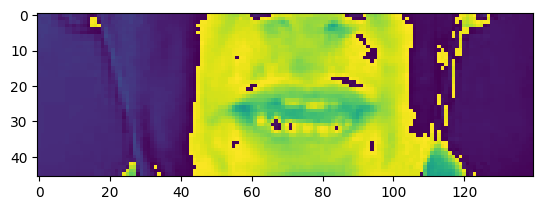

In [33]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [34]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set red at n eight now'>

# 3. Design the Deep Neural Network

* Designing the deep neural network by importing required documentaries.
* Additionally here Adam optimizer and callbacks like ModelCheckpoint and LearningRateScheduler for model training.

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [36]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

This code defines a Sequential model in TensorFlow Keras for a 3D convolutional and bidirectional LSTM network. It consists of three 3D convolutional layers with activation and max-pooling, followed by a TimeDistributed layer and two Bidirectional LSTM layers with dropout. The final layer is a Dense layer with softmax activation, producing output for character prediction. The model is designed for a specific input shape of (75, 46, 140, 1) representing video frames, and it outputs probabilities for characters in the vocabulary. Adjustments may be necessary based on the specific requirements of your task.

In [37]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [39]:
yhat = model.predict(val[0])

1/1 [==============================] - 14s 14s/step


In [40]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b't55555555555555555555555555555555555555555555555555555555555555555555555555'>

In [41]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b't55555555555555555555555555555555555555555555555555555555555555555555555555'>

In [42]:
model.input_shape

(None, 75, 46, 140, 1)

In [43]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

The scheduler function, is a learning rate scheduler used in training a deep learning model.Here, the first 30 epochs, it maintains the learning rate (lr) unchanged, and after that, it exponentially decays the learning rate by multiplying it with the exponential of -0.1.

In [44]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

Here, the below CTCLoss function computes the Connectionist Temporal Classification (CTC) loss between the ground truth labels (y_true) and the predicted probabilities (y_pred).
- It involves casting and reshaping to ensure compatibility of the model
- Then we used tf.keras.backend.ctc_batch_cost to calculate the CTC loss.
- This loss function is commonly used in sequence-to-sequence model prediction for speech and handwriting recognition.

In [45]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

- We used a custom callback in TensorFlow Keras to generate examples during training by printing the original and predicted sequences at the end of each epoch.
- It used the model to predict on a batch from the provided dataset, decoded the predictions as seen below using CTC decoding.
- It printed original and predicted sequences of text sentences for each example in the batch.
- It is useful for monitoring the model's progress and performance during training.

In [46]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

This code compiles a TensorFlow Keras model using the Adam optimizer with a learning rate of 0.001 and a custom CTC loss function. It prepares the model for training by specifying the optimization algorithm and the loss function to minimize.

Here we used the Adam optimizer with a learning rate of 0.001 and a custom CTC loss function for the preparation of the model for training by specifying the optimization and the loss function to minimize.

In [54]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss=CTCLoss)

Here we created a ModelCheckpoint callback function, which saves model weights to a file ('models/checkpoint') during training epochs, based on the 'loss' metric, and only saves the weights without the entire model.

This is useful for resuming training and also for selecting the best model based on the loss of the data during training of the model.

In [48]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

LearningRateScheduler callback function used the custom learning rate scheduler function defined earlier. This learning rate will be adjusted during training epochs based on the schedule.

In [49]:
schedule_callback = LearningRateScheduler(scheduler)

we are checking whether the model is working or not by producing a test case

In [50]:
example_callback = ProduceExample(test)

We trained the model using training dataset and validated this model against test dataset.

It runs for 10 epochs and utilizes callbacks, including ModelCheckpoint, LearningRateScheduler and a custom callback for generating random examples during the training.It took almost more than 6 hours for 10 epochs.

In [ ]:
model.fit(train, validation_data=test, epochs=10, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/10

1/1 [==============================] - 2s 2s/steps - loss: 84.40
Original: set blue with b five again
Prediction: le e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue at n four please
Prediction: le e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 2095s 5s/step - loss: 84.4042 - val_loss: 69.5367 - lr: 1.0000e-04
Epoch 2/10
1/1 [==============================] - 1s 1s/steps - loss: 71.10
Original: place green by k seven soon
Prediction: la e e e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white at n one again
Prediction: la e e e ao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 1887s 4s/step - loss: 71.1052 - val_loss: 65.5

In [ ]:
model.save("./lipnet")

INFO:tensorflow:Assets written to: ./lipnet\assets


INFO:tensorflow:Assets written to: ./lipnet\assets


# 5. Make a Prediction

Here we loaded the trained model weights from a checkpoint file, and then generates predictions on a sample from the test dataset.

In [51]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:01<00:00, 85.1MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [55]:
model.load_weights('/content/models/checkpoint')

In [56]:
test_data = test.as_numpy_iterator()

In [58]:
sample = test_data.next()

In [68]:
yhat = model.predict(sample[0])

1/1 [==============================] - 14s 14s/step


It decoded the predictions using CTC decoding and printed the real text along with the corresponding predicted text for evaluation as seen below.

In [69]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay white by l seven soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay red by l three again'>]

In [70]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [71]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay white by l seven soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay red by l three again'>]

# Test on a Video

The data is tested using a random video file from the input data. As we can below:
- the real text is getting an output of "bin blue at f three soon"
&

- the predicted sentence is "bin blue at j three soon".

As we are training with just 10 epochs there is a mistake in predicted output but most of the sentence in the lipreading is similar. thus the Lipnet model here is predicting the sentences just by lipreading almost similar to original text.

In [73]:
sample = load_data(tf.convert_to_tensor('/content/data/s1/bbaf2n.mpg'))

In [74]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>]

In [75]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 6s 6s/step


In [76]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [77]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>]